In [1]:
import os
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pydub
import keras.backend as kr

from keras.preprocessing.image import ImageDataGenerator
from pydub import AudioSegment
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.initializers import glorot_uniform

# Dataset

This project uses the GTZAN dataset. This dataset comes with 100 thirty-second long songs for 10 genres, providing a total of 1000 songs.

In [2]:
dataset_dir = 'genres_original/'
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
color_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
desired_shape = (288, 432, 4)

# Splitting the .wav files

To maximise the training performed from our dataset, each .wav file was split up into segments which will be converted to a spectrogram and used for training. By splitting up the dataset, more training and testing data is produced from a single file, and the CNN is better at evaluating segments of a song.

In [3]:
# Song segments
check_period = 3
segments_per_wav = 1

for genre_index, genre_label in enumerate(genre_labels):
    i = 0
    genre_dir = os.path.join(dataset_dir, genre_label)

    for file in os.listdir(genre_dir):        
        file_path = os.path.join(genre_dir, file)
        
        for j in range(segments_per_wav):
            y, sr = librosa.load(file_path, offset=(j * check_period), duration=check_period)
        
            path = f'./genres_split/{genre_label}/'
            if not os.path.exists(path):
                os.makedirs(path)

            sf.write(f'{path}{genre_label}{i}.wav', y, sr)

            i += 1
        
    # Debugging progress.
    print('Finished:', genre_label, i)
    
dataset_dir = 'genres_split/'

Finished: blues 100
Finished: classical 100
Finished: country 100
Finished: disco 100
Finished: hiphop 100
Finished: jazz 100
Finished: metal 100
Finished: pop 100
Finished: reggae 100
Finished: rock 100


# Conversion to Mel Spectrograms

To be able to process and extract features for classifying a songs genre, we will convert the .wav file to a spectrogram using the librosa library. We use Mel Spectrograms to pass to our CNN because it provides better frequency resolution and has the benefit of using a short-time Fourier transform with overlapping windows, which provides a good balance between time and frequency resolution.

Once the .wav file has been converted to a spectrogram, we will use matplotlib to convert it to an image and save it locally. This improves performance as we will not need to store all of the Mel Spectrograms in memory for training the CNN, they will be looked up from the local .png file.

Furthermore, to imporve speed and performance, multithreading will be used to convert multiple .wav files to spectrograms simultaniously.

In [4]:
print(dataset_dir)

def process_file(genre_label, file, i):
    # Debugging progress.
    if i % 20 == 0:
        print('processing:', genre_label, i)
    
    # Grab our .wav file.
    file_path = os.path.join(dataset_dir, genre_label, file)

    # Load our .wav file with librosa and convert it to a mel spectrogram.
    y, sr = librosa.load(file_path, duration=check_period)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Create our matplotlib figure and save the spectrogram to it. 
    # We are creating a new figure, canvas and subplot as using plt directly is not threadsafe.
    fig = plt.Figure()
    canvas = FigureCanvasAgg(fig)
    ax = fig.add_subplot(111)
    p = ax.imshow(librosa.power_to_db(spectrogram, ref=np.max), cmap='viridis')

    # Create our target directory for storing our spectrograms.
    path = f'./spectrograms/generated/{genre_label}/'
    if not os.path.exists(path):
        os.makedirs(path)

    # Save the spectrogram.
    fig.savefig(f'./spectrograms/generated/{genre_label}/{genre_label}{i}.png')
    
    
def process_genre(genre_label):
    i = 1
    genre_dir = os.path.join(dataset_dir, genre_label)

    # Iterate over each .wav file in our genre dataset.
    for file in os.listdir(genre_dir):
        # Process the .wav file.
        process_file(genre_label, file, i)
        i += 1

    # Debugging progress.
    print('Finished:', genre_label)
    
# Start our multithreading task.
def start():
    # Assing 8 threads.
    max_workers = 8
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        executor.map(process_genre, genre_labels)

# Only start multithreading on main thread.
if __name__ == '__main__':
    start()

genres_split/
processing: pop 20
processing: disco 20
processing: hiphop 20
processing: classical 20
processing: country 20
processing: jazz 20
processing: blues 20
processing: metal 20
processing: pop 40
processing: hiphop 40
processing: disco 40
processing: jazz 40
processing: blues 40
processing: classical 40
processing: country 40
processing: metal 40
processing: hiphop 60
processing: pop 60
processing: disco 60
processing: jazz 60
processing: blues 60
processing: classical 60
processing: country 60
processing: metal 60
processing: pop 80
processing: disco 80
processing: jazz 80
processing: hiphop 80
processing: blues 80
processing: classical 80
processing: metal 80
processing: country 80
processing: hiphop 100
processing: metal 100
processing: classical 100
processing: blues 100
processing: pop 100
processing: jazz 100
processing: country 100
processing: disco 100
Finished: hiphop
Finished: metal
Finished: classical
Finished: blues
Finished: pop
Finished: jazz
Finished: country
Fi

# Test Train Split

Since we are working with a collection of .png spectrograms and not data objects, we cannot use the regular test_train_split method, so we will manually extract a random set of spectrograms from each genre and move it out for our testing set.

In [5]:
directory = './spectrograms/generated/'

for genre in genre_labels:
    filenames = os.listdir(os.path.join(directory, f"{genre}"))
    
    # Shuffle all of the files in the list.
    random.shuffle(filenames)
    
    # Select the first x files from the randomized list.
    test_files = filenames[0:20]
    
    # Move the files to the testing set.
    for file in test_files:
        path = f"./testing_set/{genre}"
        
        # Create directory if it doesn't exist.
        if not os.path.exists(path):
            os.makedirs(path)
        
        # Move the file.
        shutil.move(f"{directory}{genre}/{file}", path)

Error: Destination path './testing_set/blues\blues21.png' already exists

In [6]:
# Training and testing directories.
train_directory = './spectrograms/generated/'
testing_directory = './testing_set/'

# Create our image preprocessors. Using this we will scale down all of the imaes to a better size for the CNN.
training_data = ImageDataGenerator(rescale=1./255)
testing_data = ImageDataGenerator(rescale=1./255)

scaled_training_dataset = training_data.flow_from_directory(train_directory, target_size=(288, 432), 
                                                    color_mode="rgba", class_mode='categorical', batch_size=128)

scaled_testing_dataset = testing_data.flow_from_directory(testing_directory, target_size=(288, 432), 
                                                        color_mode='rgba', class_mode='categorical', batch_size=128)

Found 998 images belonging to 10 classes.
Found 202 images belonging to 10 classes.


# Creating the model

In [7]:
def create_model(input_shape, classes):
    # Define a helper function to create a step in the CNN model.
    # This function includes a Conv2D layer, a BatchNormalization layer,
    # an Activation layer with 'relu', and finally a MaxPooling2D layer.
    def create_step_in_model(dim, input_tensor):
        # Apply a 2D convolution layer with 'dim' filters and a kernel size of 3x3.
        X = Conv2D(dim, kernel_size=(3, 3), strides=(1, 1))(input_tensor)

        # Apply batch normalization along the channels axis.
        X = BatchNormalization(axis=3)(X)

        # Apply a 'relu' activation function.
        X = Activation('relu')(X)

        # Apply a 2D max pooling operation.
        return MaxPooling2D((2, 2))(X)
    
    # Define the input shape for the model.
    X_input = Input(input_shape)

    # Initialize the first tensor to the input tensor.
    X = X_input

    # Define the dimensions of the layers in the model.
    layer_dimensions = [8, 16, 32, 64, 128, 256]

    # Create each layer in the model.
    for layer_dim in layer_dimensions:
        X = create_step_in_model(layer_dim, X)

    # Flatten the tensor.
    X = Flatten()(X)

    # Apply dropout to prevent overfitting.
    X = Dropout(rate=0.3)(X)

    # Apply a fully connected (dense) layer with 'classes' number of neurons.
    X = Dense(classes, activation='softmax',
              name=f'fc{classes}',  kernel_initializer=glorot_uniform(seed=9))(X)
    
    # Define the model with the specified inputs and outputs.
    model = Model(inputs=X_input, outputs=X, name='cnn')

    # Return the created model.
    return model


# Estimate an accuracy of the model using a bunch of keras calculations.
def f1_score(y_true, y_pred):
    # This is the number of positive instances which are correctly identified by the model.
    true_positives = kr.sum(kr.round(kr.clip(y_true * y_pred, 0, 1)))
    
    # The total number of positive instances in the true labels. 
    possible_positives = kr.sum(kr.round(kr.clip(y_true, 0, 1)))
    
    # The total number of instances that the model predicts as positive.
    predicted_positives = kr.sum(kr.round(kr.clip(y_pred, 0, 1)))
    
    # The proportion of true positive instances among all instances that the model predicts as positive.
    precision = true_positives / (predicted_positives + kr.epsilon())
    
    # The proportion of true positive instances among all actual positive instances.
    recall = true_positives / (possible_positives + kr.epsilon())
    
    # Output the final f1 score.
    return 2 * (precision * recall) / (precision + recall + kr.epsilon())

# Training our model #

Using our scaled training data and testing data for validation, we will now train our model over 100 epochs. 
This process is very time consuming with GPU acceleration (may take several minutes per epoch).

In [8]:
# Create and run our model
model = create_model(input_shape=desired_shape, classes=len(genre_labels))
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy', f1_score])
history = model.fit(scaled_training_dataset, epochs=100, validation_data=scaled_testing_dataset)

Epoch 1/100
8/8 [==============================] - 14s 1s/step - loss: 3.0049 - accuracy: 0.1102 - f1_score: 0.0295 - val_loss: 2.3031 - val_accuracy: 0.0891 - val_f1_score: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 2.6998 - accuracy: 0.1112 - f1_score: 0.0256 - val_loss: 2.3024 - val_accuracy: 0.1040 - val_f1_score: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 2.5218 - accuracy: 0.1343 - f1_score: 0.0360 - val_loss: 2.3046 - val_accuracy: 0.0990 - val_f1_score: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 2.3713 - accuracy: 0.1834 - f1_score: 0.0563 - val_loss: 2.3095 - val_accuracy: 0.0990 - val_f1_score: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 2.3083 - accuracy: 0.1954 - f1_score: 0.0782 - val_loss: 2.3144 - val_accuracy: 0.0990 - val_f1_score: 0.0000e+00
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 2.23

8/8 [==============================] - 10s 1s/step - loss: 0.2226 - accuracy: 0.9569 - f1_score: 0.9456 - val_loss: 0.1912 - val_accuracy: 0.9851 - val_f1_score: 0.9659
Epoch 91/100
8/8 [==============================] - 10s 1s/step - loss: 0.1954 - accuracy: 0.9770 - f1_score: 0.9710 - val_loss: 0.1793 - val_accuracy: 0.9851 - val_f1_score: 0.9731
Epoch 92/100
8/8 [==============================] - 10s 1s/step - loss: 0.1973 - accuracy: 0.9709 - f1_score: 0.9660 - val_loss: 0.1764 - val_accuracy: 0.9802 - val_f1_score: 0.9799
Epoch 93/100
8/8 [==============================] - 10s 1s/step - loss: 0.1919 - accuracy: 0.9749 - f1_score: 0.9672 - val_loss: 0.1799 - val_accuracy: 0.9802 - val_f1_score: 0.9745
Epoch 94/100
8/8 [==============================] - 10s 1s/step - loss: 0.1957 - accuracy: 0.9679 - f1_score: 0.9599 - val_loss: 0.1653 - val_accuracy: 0.9851 - val_f1_score: 0.9749
Epoch 95/100
8/8 [==============================] - 10s 1s/step - loss: 0.1928 - accuracy: 0.9739 - f1_

In [16]:
# Save the model locally for later use if necessary.
model.save('genre_model_98.h5', save_format='h5')

# Validating Model performance ##

To validate the performance of this model, we will plot several pieces of data to help visualize what the model was achieving during training.

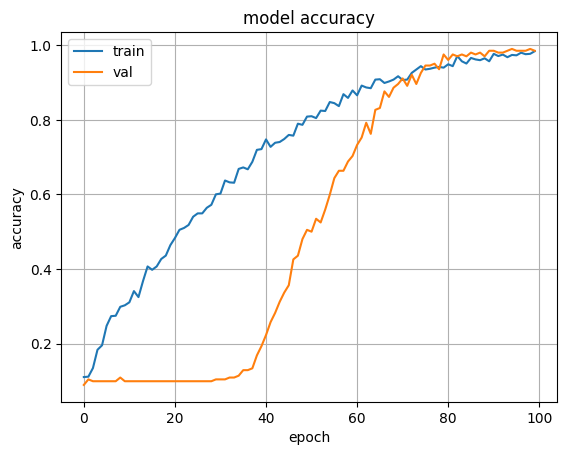

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

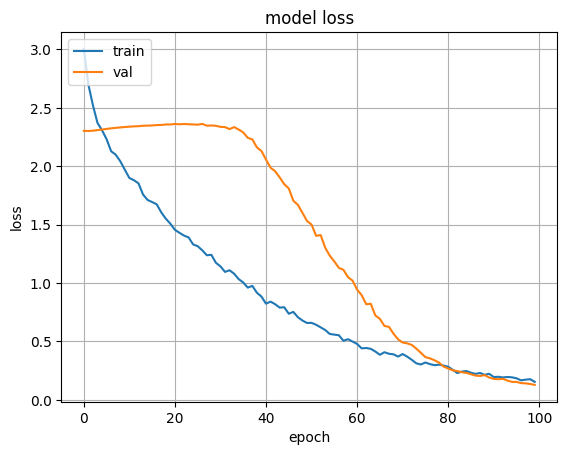

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predicting a songs genre

Now that our model is created, we can test a provided mp3 or wav file and predict its composition of genres. Much like our testing process, we simply need to generate a spectrogram for our audio file and pass that into our model to output the genre composition.

In [ ]:
# Load model if necessary.
# model = create_model(input_shape=(288, 432, 4), classes=len(genre_labels))
# model.load_weights("genre_model_double.h5")

In [11]:
# Manually set ffmpeg path to fix errors.
pydub.AudioSegment.converter = r"C:\FFmpeg\bin\ffmpeg.exe"

# Predict the genres.
def predict(image_data, model):
    image = img_to_array(image_data).reshape((1, 288, 432, 4))
    prediction = model.predict(image / 255)
    prediction = prediction.reshape((10, ))
    class_label = np.argmax(prediction)
    return class_label, prediction

# Create our wav file for conversion to spectrogram.
def create_wav(file, start, duration):
    wav = AudioSegment.from_file(file)
    start_position = 1000 * start
    wav = wav[start_position:start_position + (1000 * duration)]
    wav.export("extracted.wav", format='wav')

# Create our spectrogram from our wav file.
def create_spectrogram(wav_file):
    y, sr = librosa.load(wav_file, duration=check_period)
    mels = librosa.feature.melspectrogram(y=y, sr=sr)
    
    fig = plt.Figure()
    FigureCanvasAgg(fig)
    plt.imshow(librosa.power_to_db(mels, ref=np.max))
    
    # Save the spectrogram locally for insertion into model.
    plt.savefig('final-spectrogram.png')

1/1 [==============================] - 0s 17ms/step
pop


C:\Users\alexr\AppData\Local\Temp\ipykernel_10008\2302895409.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap('jet')


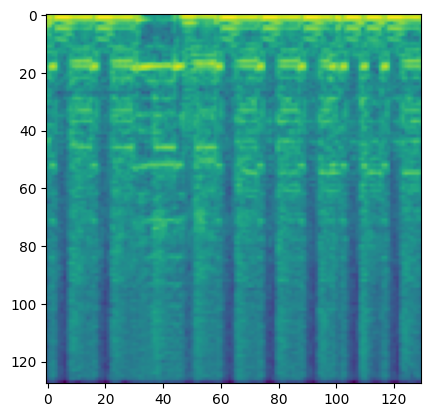

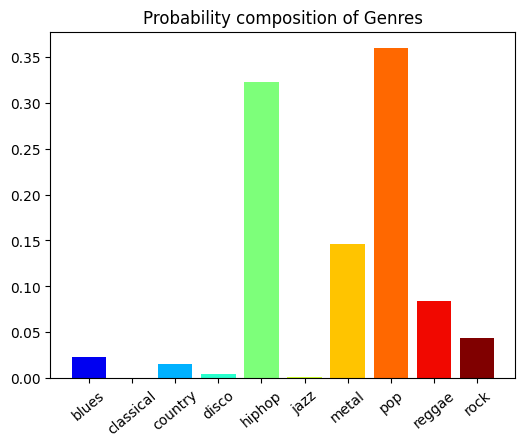

In [28]:
# The file we want to check.
test_file = 'uptempo.mp3'

create_wav(test_file, 60, check_period)
create_spectrogram("extracted.wav")
image_data = load_img('final-spectrogram.png', color_mode='rgba', target_size=(288, 432))

class_label, prediction = predict(image_data, model)
prediction = prediction.reshape((10,))

print(genre_labels[class_label])

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=10)

st.write(f"### Genre Prediction: {genre_labels[class_label]}")
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.bar(x=genre_labels, height=prediction,
       color=my_cmap(my_norm(color_data)))

plt.xticks(rotation=40)
ax.set_title("Probability composition of Genres")
st.pyplot(fig)

st.write(f"### Mel Spectrogram")
st.image("melspectrogram.png", use_column_width=True)
plt.show()